In [57]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt

%matplotlib inline

In [176]:
# %load ../kiwi/dataloader.py
import numpy as np
import cv2
import os
import imghdr
import skimage

ROOT_PATH = os.path.abspath('../')

def prepare_image(fullpath):
  """ Resize the image, convert it to gray scale and flatten the array """
  image = cv2.imread(fullpath, 0) # load as grayscale
  resized = cv2.resize(image, (32,32))
  final = resized[..., None] # add missing channel
  return final

def from_folder(target_folder):
  """ Transform the data into an input/output format suitable for model training
  Images are loaded as arrays """
  data_dir = os.path.join(ROOT_PATH, target_folder)
  classes = [c for c in os.listdir(data_dir)
               if os.path.isdir(os.path.join(data_dir, c))]

  print("Grabbing files for %s classes..." % len(classes))
  X_data = []
  Y_data = []
  for class_id in classes:
    class_folder = os.path.join(data_dir, class_id)
    for file in os.listdir(class_folder):
      if os.path.basename(os.path.join(class_folder, file)): # images only
        image_path = os.path.join(ROOT_PATH, data_dir, class_id, file)
        X_data.append(prepare_image(image_path))
        Y_data.append(int(class_id))

  return np.array(X_data), np.array(Y_data)

def from_infer_folder(target_folder):
  """ Transform the data into a format suitable for model prediction """
  X_data = []
  files = []
  data_dir = os.path.join(ROOT_PATH, target_folder)
  print("Loading images from", data_dir)
  for file in os.listdir(data_dir):
    image_path = os.path.join(ROOT_PATH, data_dir, file)
    if os.path.basename(image_path) and imghdr.what(image_path):
      X_data.append(prepare_image(image_path))
      files.append(image_path)
  
  print("Found %s file(s)" % len(X_data))
  return np.array(X_data), files

In [177]:
X_data, Y_data = from_folder('images/train')
X_test, Y_test = from_folder('images/test')
print('X: %s, Y: %s' % (X_data.shape, Y_data.shape))
print('Xt: %s, Yt: %s' % (X_test.shape, Y_test.shape))

Grabbing files for 43 classes...
Grabbing files for 43 classes...
X: (954, 32, 32, 1), Y: (954,)
Xt: (259, 32, 32, 1), Yt: (259,)


In [178]:
# One-hot vector
################

classes = np.array(range(0,43))
y_enc = LabelEncoder().fit_transform(classes)
lblbin = LabelBinarizer().fit(y_enc)

Y_data_bin = lblbin.transform(Y_data)
Y_test_bin = lblbin.transform(Y_test)
Y_data_bin.shape

(954, 43)

# Model training

In [39]:
# zero-pading wrapping
arr = np.array([[1,1,1],[2,2,2],[3,3,3]])
print(arr.shape)
pad = np.pad(arr, 1, mode='constant', constant_values=0)
print(pad.shape)

(3, 3)
(5, 5)


In [204]:
# LeNet-5 Graph Definition
##########################

EPOCHS = 300
BATCH_SIZE = 128
CLASSES_SIZE = 43
LEARNING_RATE = 0.001 #1e-4

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    layer_units = {
        'C1' : 6,
        'C3' : 16,
        'C5' : 120,
        'F6' : 84,
        'F7' : CLASSES_SIZE, # originally 10, changed to match Traffic Signs classes
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    C1_w = tf.Variable(tf.truncated_normal(shape=[5,5,1,6], mean=mu, stddev=sigma))
    C1_b = tf.Variable(tf.zeros(layer_units['C1']))
    C1 = tf.nn.conv2d(x, C1_w, strides=[1,1,1,1], padding='VALID') + C1_b 
    C1 = tf.nn.relu(C1)
    
    # Layer 2: Pooling. Input = 28x28x6. Output = 14x14x6.
    S2 = tf.nn.max_pool(C1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 3: Convolutional. Output = 10x10x16.
    C3_w = tf.Variable(tf.truncated_normal(shape=[5,5,6,16], mean=mu, stddev=sigma))
    C3_b = tf.Variable(tf.zeros(layer_units['C3']))
    C3 = tf.nn.conv2d(S2, C3_w, strides=[1,1,1,1], padding='VALID') + C3_b
    C3 = tf.nn.relu(C3)
    
    # Layer 4: Pooling. Input = 10x10x16. Output = 5x5x16.
    S4 = tf.nn.max_pool(C3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    #Flatten. Input = 5x5x16. Output = 400.
    C5 = flatten(S4)
    
    # Layer 5: Convolutional/Fully Connected. Input = 400. Output = 120.
    # Feature map is 1x1 because S4 is also 5x5 (practically fully-connected unless LenNet grows)
    C5_w = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    C5_b = tf.Variable(tf.zeros(layer_units['C5']))
    C5 = tf.matmul(C5, C5_w) + C5_b
    C5 = tf.nn.relu(C5)
    
    # Layer 6: Fully Connected. Input = 120. Output = 84.
    F6_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    F6_b = tf.Variable(tf.zeros(layer_units['F6']))
    F6 = tf.matmul(C5, F6_w) + F6_b
    F6 = tf.nn.relu(F6)
    
    # Layer 7: Fully Connected. Input = 84. Output = 43 (Originally 10).
    F7_w = tf.Variable(tf.truncated_normal(shape=(84,CLASSES_SIZE), mean=mu , stddev=sigma))
    F7_b = tf.Variable(tf.zeros(layer_units['F7']))
    logits = tf.matmul(F6, F7_w) + F7_b
    
    return logits

In [193]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, CLASSES_SIZE)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [194]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [216]:
model_target_path = os.path.join(ROOT_PATH, 'models/model3/saved/lenet5')

train_acc = []
test_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_data)
  
    print("Training model...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_data, Y_data)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_data[offset:end], Y_data[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
            # plot data
            train_acc.append(evaluate(X_data, Y_data))
            test_acc.append(evaluate(X_test, Y_test))
       
        if (i+1) % 10 == 0:
            validation_accuracy = evaluate(X_test, Y_test)
            print("Epoch {}, Accuracy = {:.2f}%".format(i+1, validation_accuracy*100))
        
    saved_path = saver.save(sess, model_target_path)
    print("Model persisted at", saved_path)

Training model...
Epoch 10, Accuracy = 40.93%
Epoch 20, Accuracy = 71.43%
Epoch 30, Accuracy = 73.75%
Epoch 40, Accuracy = 72.97%
Epoch 50, Accuracy = 77.61%
Epoch 60, Accuracy = 78.76%
Epoch 70, Accuracy = 79.15%
Epoch 80, Accuracy = 79.54%
Epoch 90, Accuracy = 79.54%
Epoch 100, Accuracy = 79.15%
Epoch 110, Accuracy = 78.76%
Epoch 120, Accuracy = 79.15%
Epoch 130, Accuracy = 79.92%
Epoch 140, Accuracy = 80.31%
Epoch 150, Accuracy = 80.31%
Epoch 160, Accuracy = 80.31%
Epoch 170, Accuracy = 80.31%
Epoch 180, Accuracy = 80.31%
Epoch 190, Accuracy = 79.92%
Epoch 200, Accuracy = 79.92%
Epoch 210, Accuracy = 79.92%
Epoch 220, Accuracy = 80.31%
Epoch 230, Accuracy = 80.31%
Epoch 240, Accuracy = 80.31%
Epoch 250, Accuracy = 80.31%
Epoch 260, Accuracy = 80.31%
Epoch 270, Accuracy = 80.31%
Epoch 280, Accuracy = 80.69%
Epoch 290, Accuracy = 80.69%
Epoch 300, Accuracy = 80.69%
Model persisted at /Users/orendon/dev/ml/German-Traffic-Signs-Detector/models/model3/saved/lenet5


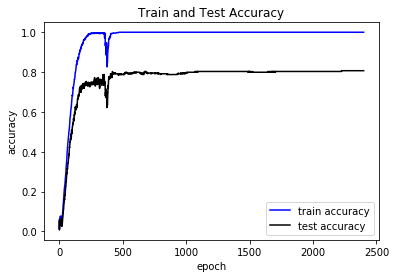

In [218]:
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()